# Monthly anomaly

This script allows user to compute anomaly on a selected month and year using the full Sentinel 2 imagery for the selected month.

1. Extract a mini dataset for selected area and month
1. Apply a mask
1. Apply mathematical expression to all dates & calculate mean (to be used as baseline)
1. Extract selected year & calculate mean
1. Calculate anomaly the inverse way of CEOS example ((selected - baseline) / baseline)
1. Compute quality and add it to dataset_out

### Main input parameters:

- **anom_year** & **anom_month**: year and month to compute anomaly (mean compared with mean of all available scenes for the selected month)
- **bands**: bands needed by the mathematical expression
- **math_expr**: mathematical expression to apply on **bands**
- **cat_band**: band containing the classification (either *slc* or *cf_mask* for respectively Sentinel 2 or Landsat products
- **keep_cats**: categories of cat_band considered as data (see table below)
- **chunk_size** = chunk area (benchmark showed 0.15 is the best value (in used hardware) in the case of a 2 bands expression)
- **dis_range**: values range to display (to be zero centered it has to be symetrical) on figures

![](diagrams/documentation/mask_bands_table.png)

For example using **cat_band = 'slc'** with **keep_cats = [4]** will compute the anomaly on pixel classified as vegetated only (see below figure with French Geoportail Ortophoto as a background).

![](diagrams/documentation/s2_monthly_anomaly_veg_only.png)

For more details see *Configuration* section and *expr_anom* function below


### Output:
- Percentage of change (anomaly)
- Output quality (percentage of pixel with data (through time) baseline * selected)

![](diagrams/documentation/ndvi_anomaly_products.png)

Outputs are available as

- geotiff (full dataset, integer format using "deflate" compression (*compress="deflate" added to utils/dc_utilities.py write_geotiff_from_xr*))
- figures (in script): maps & histograms (restricted to **dis_range** values)

![](diagrams/documentation/monthy_anomaly_output.png)

In [1]:
# Import dependencies
%matplotlib inline

import os
from datetime import datetime
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio

import datacube
import utils.dc_mosaic
from swiss_utils.sdc_utilities import easy_map, easy_export
from utils.dc_chunker import create_geographic_chunks, combine_geographic_chunks

dc = datacube.Datacube()
api = datacube.api.API()

import warnings
warnings.simplefilter('ignore')

In [2]:
# Configuration section - 0.1° AOI
# AOI
platform = "SENTINEL_2"
product = "s2_l2a_10m_swiss"
min_lon =  6.88
max_lon =  6.98
min_lat = 45.45
max_lat = 45.54
# year and month for anomaly calculation
anom_year = 2018         # Year to compute anomaly
anom_month = 7           # Month to compute anomaly
# bands and mathematical expression to apply (each band need "dataset_in" prefix)
bands = ['red', 'nir']   # Bands to compute NDVI
math_expr = "(dataset_in.nir - dataset_in.red) / (dataset_in.nir + dataset_in.red)"
# mask band and data categories
cat_band = 'slc'         # Band containing the classification, to be used to create the mask
keep_cats = [4]          # Categories of cat_band considered as data (vegetation)

chunk_size = 0.15        # Chunk area
dis_range = [-20, 20]  # Values range to display (to be zero centered it has to be symetrical)

In [3]:
# Display AOI (OPTIONAL)
from utils.dc_display_map import display_map
display_map(latitude = (min_lat, max_lat), longitude = (min_lon, max_lon))

# Functions

In [4]:
# Function to convert a tupple to a condition
# Workaround as xa.apply_ufunc is not implemented in this version (0.9.6) of xarray
def tupple_to_cond(cats):
    for m in range(1,len(cats)+1):
        if m == 1: cond_cats = '(cat_arr == %i)' % (cats[m-1])
        else: cond_cats = '%s | (cat_arr == %i)' % (cond_cats, cats[m-1])
    return cond_cats

In [5]:
def expr_anom(plat, prod, expr, bands_expr, mask, data_cats, year, month, lon, lat):
    """
    Description:
      Compute anomaly between a baseline (mean of all available scene for a given month)
      and a selected month (mean value as well) after the application of a given methematical
      expression such as calculation of NDVI.
    -----
    Input:
      plat: DC platform
      prod: DC product
      expr: mathematic expression to apply on bands (need dataset_in prefix for each band)
      bands_expr: bands used in the expr
      mask_band: classified band to mask nodata
      data_cats: categories considered as containing data in mask_band
      year: selected year for anomaly computation
      month: selected month for anomaly computation
      lon: longitude (min, max)
      lat: latitude (min, max)
    Output:
      a single dataset (dataset out) containing 2 layers
        - pc_change: anomaly in percent ((selected mont/year - baseline) / baseline)
        - qual: quality (percentage of pixel with data,  baseline * selected )
    """

    # add mask band if necessary
    if mask not in bands_expr: bands_expr = bands_expr + [mask,]

    # 1.Extract a mini dataset for selected area and month
    # Get a Mini Data Cube
    dataset_in = dc.load(platform=plat,
                         product=prod,
                         lon=lon,
                         lat=lat,
                         measurements=bands_expr)
    # Filter by selected month
    dataset_in = dataset_in.sel(time=np.equal(month, dataset_in['time.month']))

    # 2.Apply a mask
    # Create mask
    cat_arr = dataset_in[mask]
    clean_mask = eval(tupple_to_cond(data_cats))
    # Remove unecessary stuff
    del cat_arr
    dataset_in = dataset_in.drop(mask)
    # Apply the mask
    dataset_in = dataset_in.where(clean_mask)
    # Calculate baseline data completness
    data_pc_baseline = clean_mask.where(clean_mask).sum('time') / len(clean_mask)

    # 3. Apply mathematical expression to all dates & calculate mean (to be used as baseline)
    expr_scenes = eval(expr)
    expr_baseline = expr_scenes.mean(dim='time', skipna=True, keep_attrs=False)

    # 4. Extract selected year & calculate mean
    # Filter by selected year
    dataset_in = dataset_in.sel(time=np.equal(year, dataset_in['time.year']))
    clean_mask = clean_mask.sel(time=np.equal(year, clean_mask['time.year']))
    expr_scenes = eval(expr)
    del dataset_in
    expr_scene = expr_scenes.mean(dim='time', skipna=True, keep_attrs=False)
    # Calculate selected year data completness
    data_pc_scene = clean_mask.where(clean_mask).sum('time') / len(clean_mask)
    del clean_mask

    # 5.Calculate anomaly the inverse way of CEOS example ((selected - baseline) / baseline)
    percentage_change = np.rint((expr_scene - expr_baseline) / expr_baseline * 100).astype(rasterio.int16)
    del expr_baseline
    del expr_scene
    dataset_out = percentage_change.to_dataset(name="pc_change")
    del percentage_change
    
    # 6. Compute quality and add it to dataset_out
    dataset_out['qual'] = np.rint(data_pc_baseline * data_pc_scene * 100).astype(rasterio.uint8)
    del data_pc_baseline
    del data_pc_scene
    
    # Fix nodata issues
    dataset_out['pc_change'] = dataset_out.pc_change.where(dataset_out.qual != 0)
    dataset_out['qual'] = dataset_out.qual.where(dataset_out.qual != 0)
    
    return dataset_out

In [6]:
# Compute anomaly
time_start = datetime.now()

if ((max_lon - min_lon) * (max_lat - min_lat) <= chunk_size):
    # Compute anomaly at once
    print('%s - processing all at once' % (datetime.now()))
    anom = expr_anom(platform, product,math_expr, bands, cat_band, keep_cats,
                     anom_year, anom_month, (min_lon, max_lon), (min_lat, max_lat))
else:
    # Compute anomaly by chunk
    # Cut the geographic extents into chunks
    geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat), longitude=(min_lon, max_lon), geographic_chunk_size=chunk_size)
    # Loop through chunks
    cnt = 0
    chunks_nb = len(geographic_chunks)
    product_chunks = []
    for index, chunk in enumerate(geographic_chunks):
        cnt += 1
        print('%s - %i/%i' % (datetime.now(), cnt, chunks_nb))
        pc_change = expr_anom(platform, product,math_expr, bands, cat_band, keep_cats,
                              anom_year, anom_month, chunk['longitude'], chunk['latitude'])
        # Append result
        product_chunks.append(pc_change)
        # Combine chunks 
    anom = combine_geographic_chunks(product_chunks)
    
print('Done in %s' % (datetime.now()-time_start))

2018-09-28 14:51:59.862104 - processing all at once
Done in 0:00:17.877967


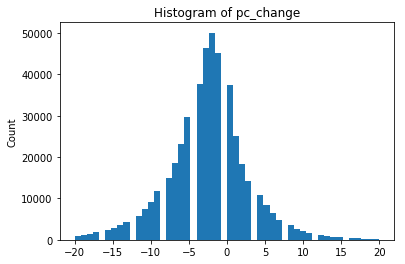

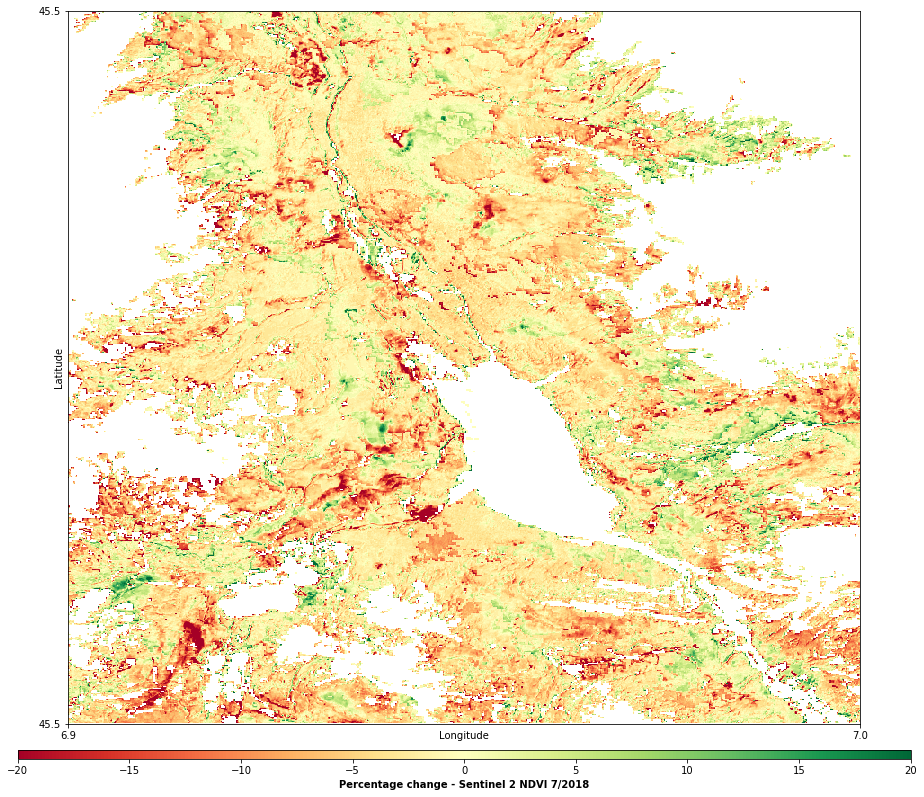

In [7]:
# pc_change output

# Export to DEFLATE compressed geotiff
# compress="deflate" added to utils/dc_utilities.py write_geotiff_from_xr
easy_export(anom.pc_change, "ndvi_pc_change_%i_%i" % (anom_month, anom_year), "tif")

# Plot histogram
anom.pc_change.plot.hist(bins=50, range=dis_range)
plt.savefig("ndvi_pc_change_%i-%i_histo.png" % (anom_month, anom_year), bbox_inches='tight')

# Constrains values range for display
anom.pc_change.values[anom.pc_change < dis_range[0]] = dis_range[0]
anom.pc_change.values[anom.pc_change > dis_range[1]] = dis_range[1]

# Preview a specific scenes and band
easy_map(anom.pc_change, 'RdYlGn', 'Percentage change - Sentinel 2 NDVI %i/%i' % (anom_month, anom_year), 16)
plt.savefig("ndvi_pc_change_%i-%i_fig.png" % (anom_month, anom_year), bbox_inches='tight')

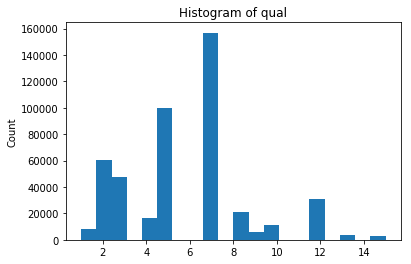

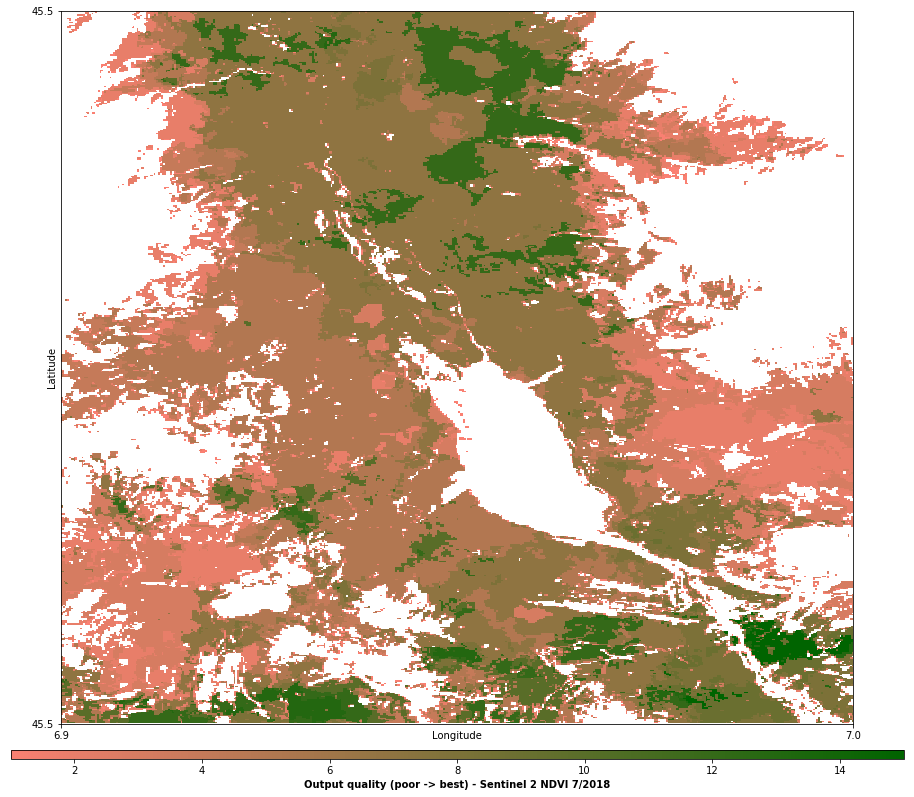

In [8]:
# qual output

# Export to DEFLATE compressed geotiff
# compress="deflate" added to utils/dc_utilities.py write_geotiff_from_xr
easy_export(anom.qual, "ndvi_quality_%i-%i" % (anom_month, anom_year), "tif")

# Compute histogram
anom.qual.plot.hist(bins=20)
plt.savefig("ndvi_quality_%i-%i_histo.png" % (anom_month, anom_year), bbox_inches='tight')

# OPTIONAL - Preview a specific scenes and band
easy_map(anom.qual,
         colors.LinearSegmentedColormap.from_list('RdGn', ['salmon','darkgreen'], N=256),
         'Output quality (poor -> best) - Sentinel 2 NDVI %i/%i' % (anom_month, anom_year),
         16)
plt.savefig("ndvi_quality_%i-%i_fig.png" % (anom_month, anom_year), bbox_inches='tight')